In [1]:
import sys
sys.path.append("..")

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch.multiprocessing as mp
mp.set_start_method('spawn')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from src.utils import project_root
from src.data.free_spoken_digits import FreeSpokenDigits, Collator, Featurizer
from src.model.model import Model



In [2]:
from matplotlib import pyplot as plt

In [3]:

dataset = FreeSpokenDigits(
    project_root()/"data/free_spoken_digits/free-spoken-digit-dataset-master"
)

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)




train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=32,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=64, hidden_size=128).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



  0%|          | 0/85 [00:00<?, ?it/s]/home/user/grandeur/notebooks/../src/data/free_spoken_digits.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  length = (length - self.featurizer.win_length) // self.featurizer.hop_length
  0%|          | 0/10 [00:03<?, ?it/s]


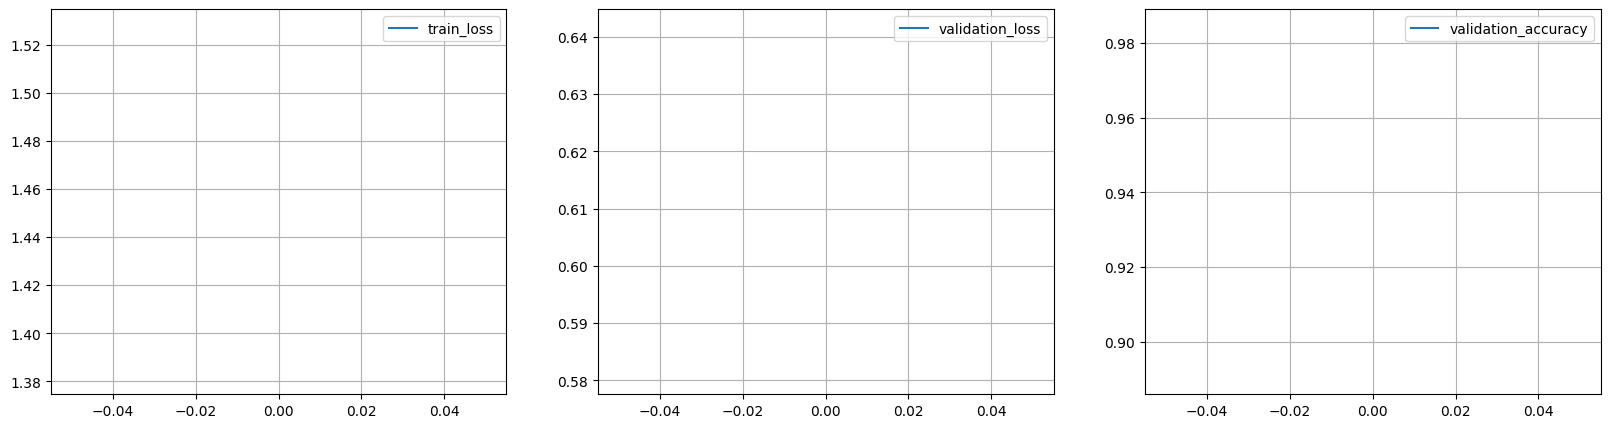

  0%|          | 0/10 [00:02<?, ?it/s]


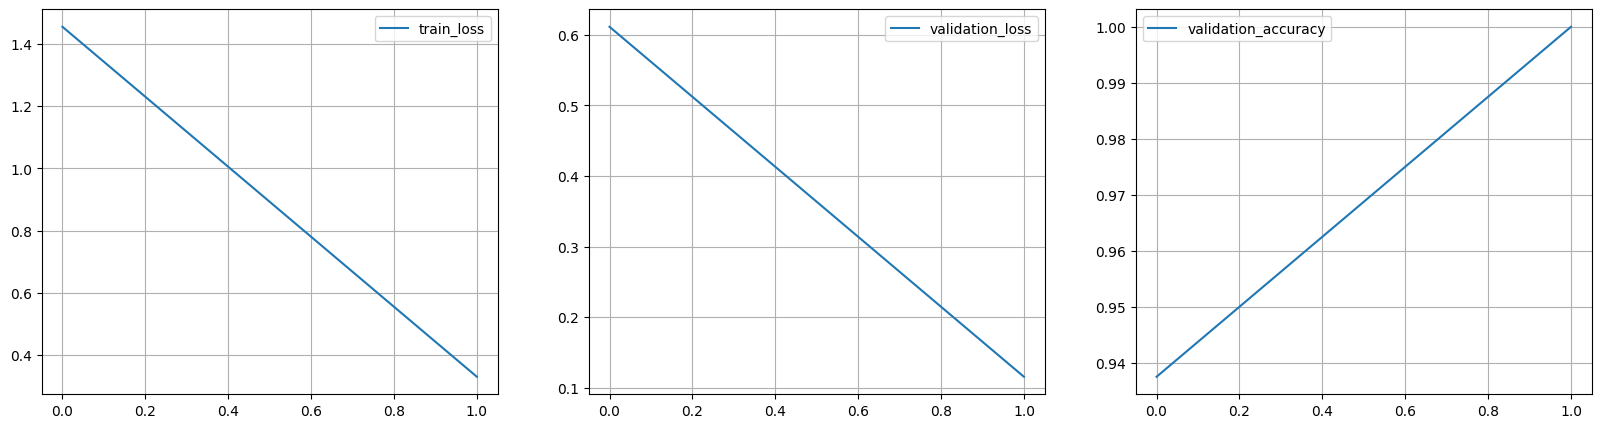

  0%|          | 0/10 [00:02<?, ?it/s]


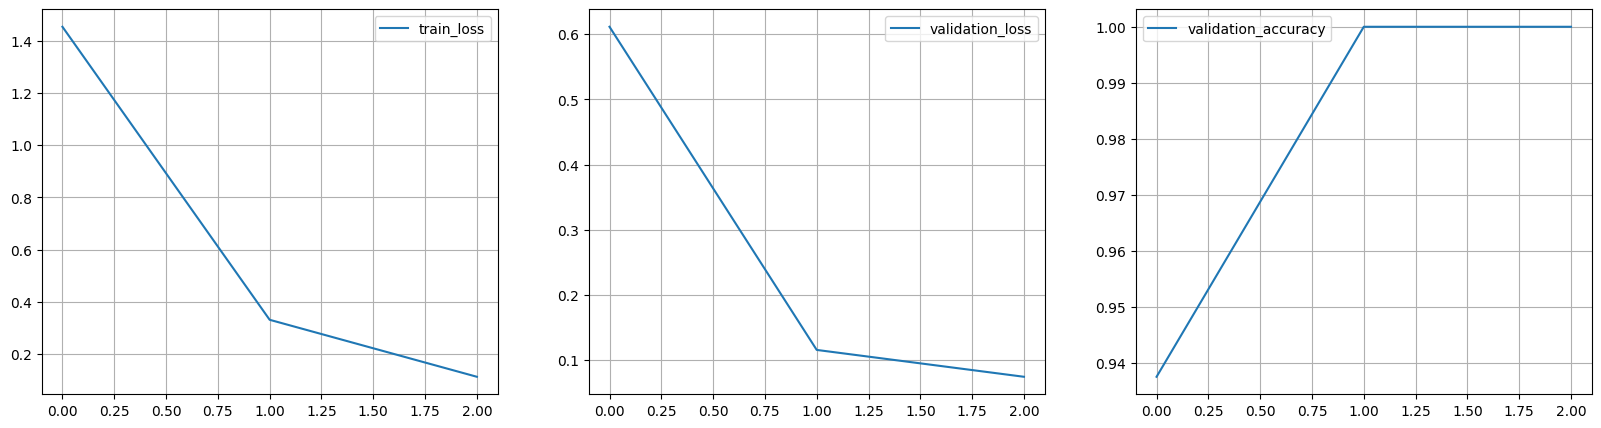

  0%|          | 0/10 [00:02<?, ?it/s]


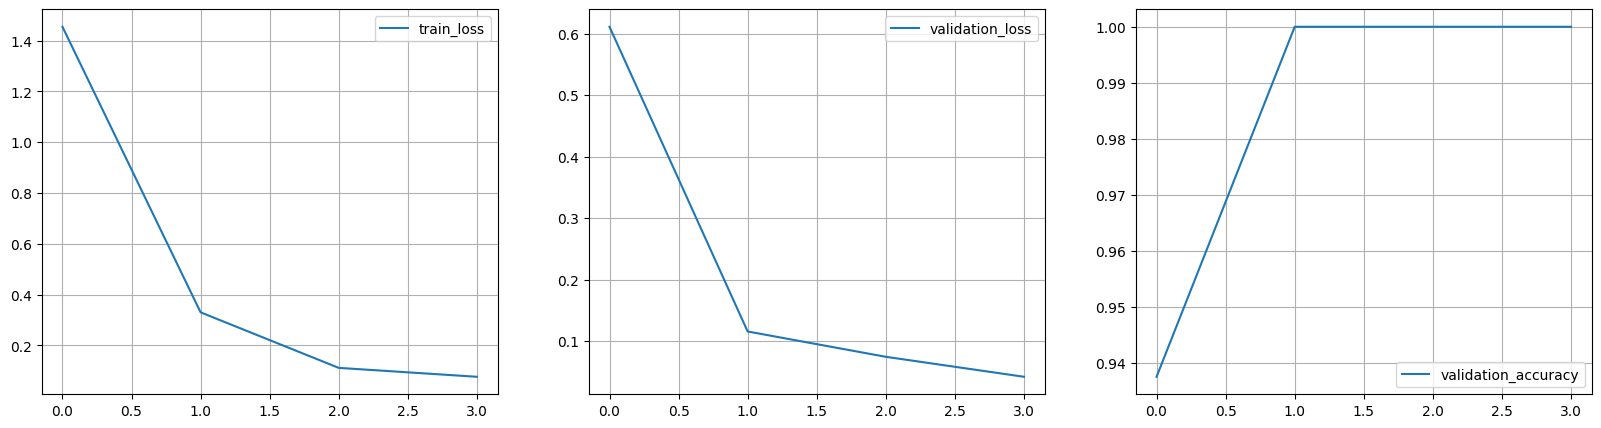

  0%|          | 0/10 [00:02<?, ?it/s]


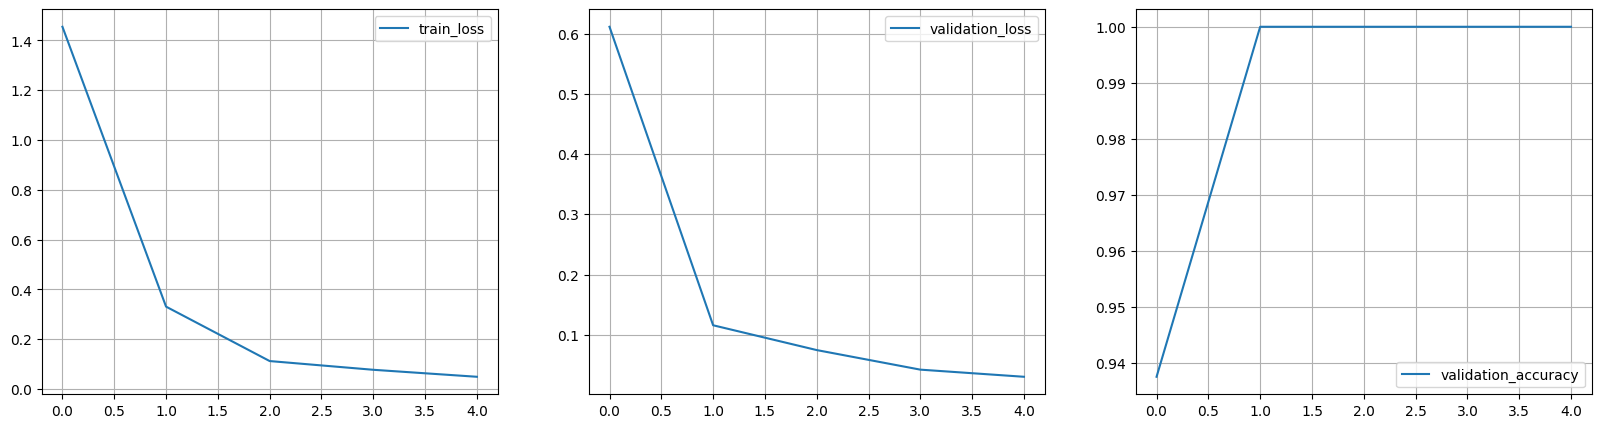

  0%|          | 0/10 [00:02<?, ?it/s]


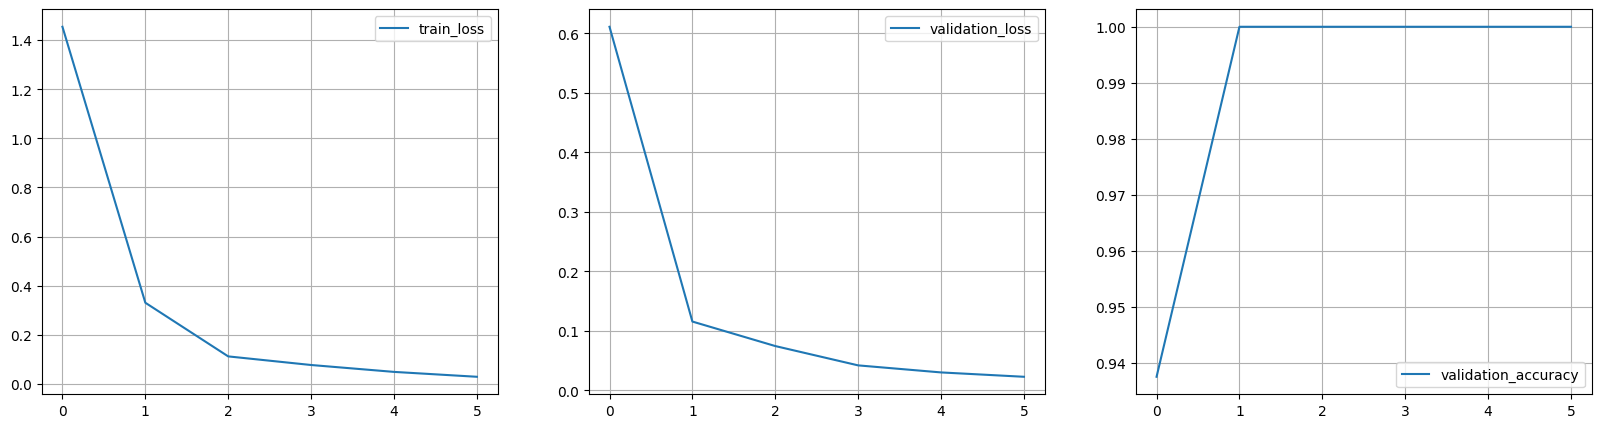

  0%|          | 0/10 [00:02<?, ?it/s]


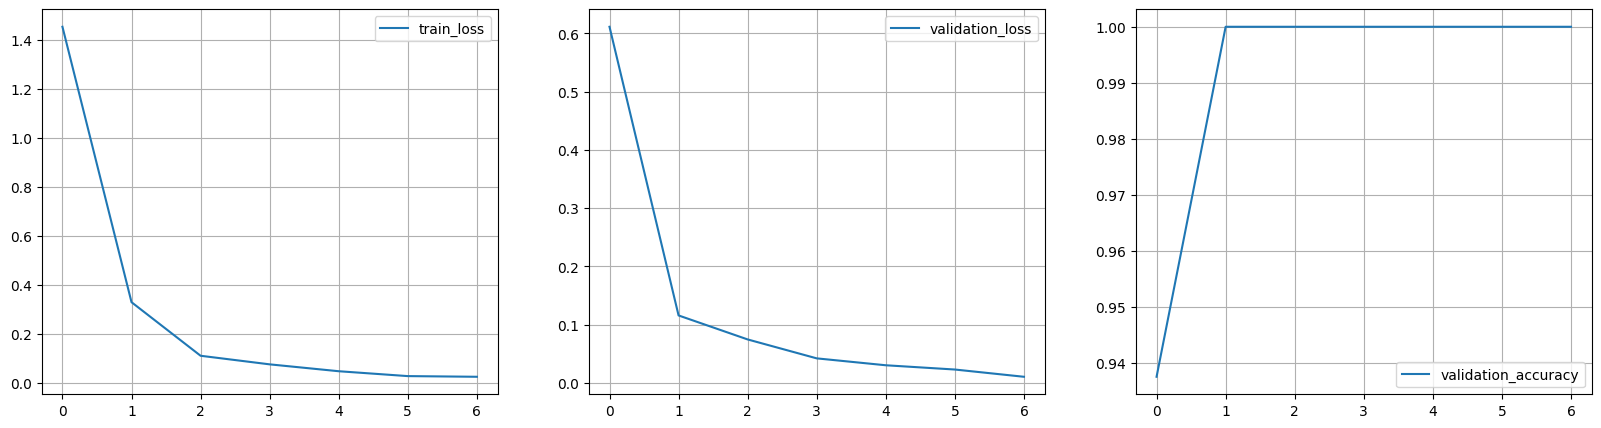

  0%|          | 0/10 [00:02<?, ?it/s]


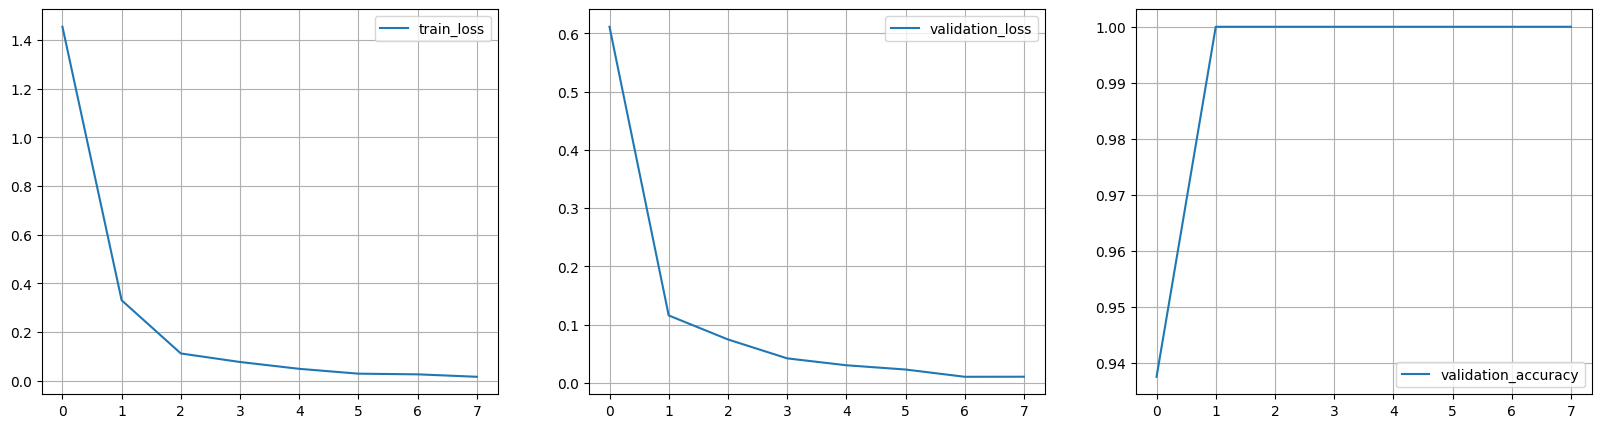

  0%|          | 0/10 [00:02<?, ?it/s]


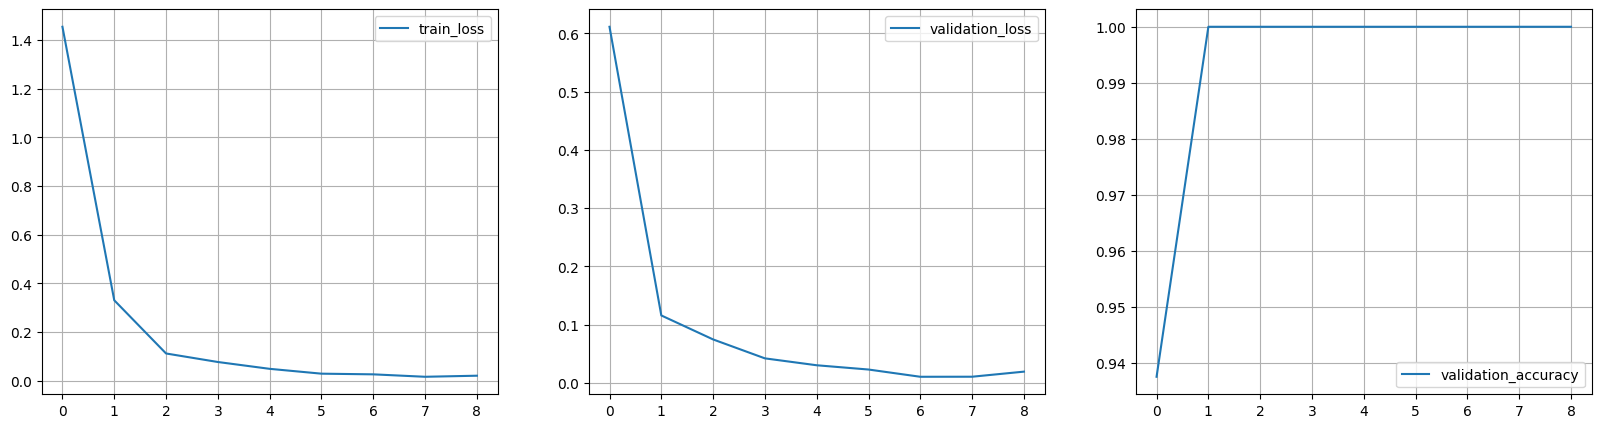

  0%|          | 0/10 [00:02<?, ?it/s]


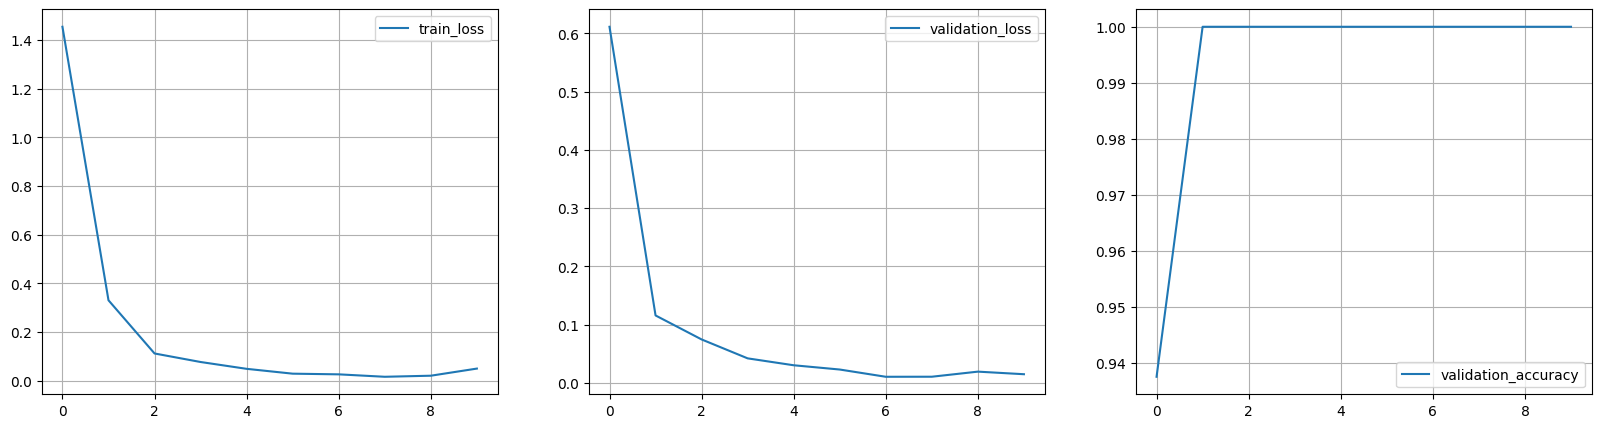

In [4]:
storage = defaultdict(list)
num_epoch = 10

for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device, non_blocking=True)
        length = batch['length'].to(device, non_blocking=True)
        label = batch['label'].to(device, non_blocking=True)

        mel, mel_length = featurizer(wav, length)
        output = model(mel, mel_length)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item())

    storage['train_loss'].append(train_loss_meter.avg)

    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)

        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())

    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)


    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        axes[i].legend()

    plt.show()

In [7]:
from IPython import display

def inference(dataloader, take_n=10):
    batch = next(iter(dataloader))
    wav = batch['wav'].to(device, non_blocking=True)[:take_n]
    length = batch['length'].to(device, non_blocking=True)[:take_n]
    label = batch['label'].to(device, non_blocking=True)[:take_n]
    
    mel_inputs, mel_length = featurizer(wav, length)
    outputs = model(mel_inputs, mel_length)
    classes = outputs.argmax(-1)
    
    for i in range(take_n):
        display.display(display.Audio(data=wav[i].cpu().numpy(), rate=8000))
        print(classes[i])
    

In [6]:
inference(validation_dataloader, take_n=3)

tensor(2, device='cuda:0')


tensor(3, device='cuda:0')


tensor(0, device='cuda:0')


In [8]:
model

Model(
  (rnn): LSTM(64, 128, batch_first=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
model_path = project_root()/"ckpt/free_spoken_digits.ckpt"

In [11]:
torch.save(model.eval(), model_path)

In [12]:
loaded_model = torch.load(model_path, map_location=torch.device("cpu"))

In [13]:
loaded_model

Model(
  (rnn): LSTM(64, 128, batch_first=True)
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
import torchaudio

In [14]:
infer_audio_path = project_root()/"data/one.m4a"

In [18]:
wav.shape

torch.Size([1, 37888])

In [ ]:
import torchaudio.functional as F


wav, sr = torchaudio.load(infer_audio_path)

resampled_waveform = F.resample(waveform, sr, resample_rate, rolloff=0.99)

In [ ]:
    batch = next(iter(dataloader))
    wav = batch['wav'].to(device, non_blocking=True)[:take_n]
    length = batch['length'].to(device, non_blocking=True)[:take_n]
    label = batch['label'].to(device, non_blocking=True)[:take_n]
    
    mel_inputs, mel_length = featurizer(wav, length)
    outputs = model(mel_inputs, mel_length)
    classes = outputs.argmax(-1)
    
    for i in range(take_n):
        display.display(display.Audio(data=wav[i].cpu().numpy(), rate=8000))
        print(classes[i])